In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from gekko import GEKKO
from tqdm import tqdm
import time
import pandas as pd
import math

## Necessary Functions

In [23]:
samples = np.load('../parameter_estimation/real_samples.npy')

In [24]:
samples

array([[4.84544116e-01, 2.11675946e-02, 9.34337165e-01, 2.83305351e-02,
        3.34613693e+01, 6.17661369e+00],
       [5.05814275e-01, 2.30559055e-02, 8.89601491e-01, 2.74588130e-02,
        3.35429588e+01, 5.98736957e+00],
       [5.63134797e-01, 2.62214729e-02, 8.19272623e-01, 2.42748427e-02,
        3.38971324e+01, 5.77982365e+00],
       ...,
       [4.96956530e-01, 2.83097483e-02, 8.38342280e-01, 2.48454905e-02,
        3.29493584e+01, 5.27483233e+00],
       [5.56716835e-01, 3.03156656e-02, 7.62280874e-01, 2.26436713e-02,
        3.13251597e+01, 5.74010092e+00],
       [5.56716835e-01, 3.03156656e-02, 7.62280874e-01, 2.26436713e-02,
        3.13251597e+01, 5.74010092e+00]], shape=(49001, 6))

In [25]:
parameters = np.mean(samples, axis=0)  # Use the mean of the samples for parameters

In [26]:
parameters

array([5.44311290e-01, 2.75725756e-02, 8.01066297e-01, 2.39429855e-02,
       3.43999173e+01, 5.83874106e+00])

In [27]:
def pred_prey(t, population, params):
    prey, predator = population
    dpdt = params[0] * prey - params[1] * prey * predator
    drdt = -params[2] * predator + params[3] * prey * predator
    return [dpdt, drdt] 

def pred_prey_model(params, t_eval):
    z0 = [params[4], params[5]]  # Initial conditions for prey and predator
    def ode(t, z):
        return pred_prey(t, z, params)  
    t_span = (t_eval[0], t_eval[-1])
    sol = solve_ivp(ode, t_span, z0, t_eval=t_eval, method='RK45')
    return sol

In [28]:
t_uncontrolled = np.linspace(0, 20, 60)  # Changed from 101 to 60 points
uncontrolled_solution = pred_prey_model(parameters, t_uncontrolled)

In [29]:
# initial conditions for control period (populations at year 20)
prey_0 = uncontrolled_solution.y[0][-1] #prey population at year 20
pred_0 = uncontrolled_solution.y[1][-1] #predator population at year 20A

In [30]:
def optimal_control(my_parameters, prey_initial, pred_initial, t_control_start=20, t_control_end=40, n_points_control=60):  # extended to 40 years with 60 points
    m = GEKKO(remote=False) 
    
    m.time = np.linspace(t_control_start, t_control_end, n_points_control)
    
    # extract parameters
    a, b, c, d = my_parameters[:4]

    # steady state values for this parameter set
    steady_prey = c / d     
    steady_predator = a / b  
    
    # use parameter-specific initial conditions for control period
    # define variables for control period
    prey = m.Var(value =  prey_initial, lb=0)   
    predator = m.Var(value = pred_initial, lb=0) 
    
    control = m.MV(value = 0, lb = -10, ub=10) 
    control.STATUS = 1  
    
    # model equations with control
    m.Equation(prey.dt() == a * prey - b * prey * predator)
    m.Equation(predator.dt() == -c * predator + d * prey * predator - control)

    m.Obj(m.integral(control**2) + ((prey - steady_prey)**2 + (predator - steady_predator)**2))

    m.options.IMODE = 6 
    m.options.SOLVER = 3
    
    return m, prey, predator, control

## Main Function

In [31]:
def run_gekko(p_matrix):
    # initialize counters + trajectories list outside the loop
    failures = 0
    successes = 0
    trajectories = []
    error_messages = []  # track error messages

    time_start = time.time()
    
    # add progress bar for the parameter sets
    for i, parameters in enumerate(tqdm(p_matrix, desc="Processing parameter sets", unit="param")):
        params = parameters[:4]
        initial = parameters[4:6]

        try:
            # first, simulate the uncontrolled period for this parameter set to get initial conditions at t=20
            params_full = np.concatenate([params, initial])  # full parameter set including initial conditions
            uncontrolled_traj = pred_prey_model(params_full, t_uncontrolled)
            
            # get the populations at year 20 for this specific parameter set
            prey_20 = uncontrolled_traj.y[0][-1]  # prey population at year 20 for this parameter set
            pred_20 = uncontrolled_traj.y[1][-1]  # predator population at year 20 for this parameter set
            
            # Debug: check if populations are reasonable
            if prey_20 <= 0 or pred_20 <= 0 or np.isnan(prey_20) or np.isnan(pred_20):
                failures += 1
                continue
                
            # use these parameter-specific initial conditions for optimal control
            model, prey, predator, control = optimal_control(params, prey_20, pred_20)
            
            # solve the optimization problem using the TRUE parameter model
            model.solve(disp=False)  # disp=False suppresses solver output
            
            # extract results from the TRUE parameter model
            t_controlled = model.time
            prey_controlled = prey.value
            predator_controlled = predator.value
            control_signal = control.value  # this is pesticide application rate
            
            if len(t_controlled) == 0 or len(prey_controlled) == 0 or len(predator_controlled) == 0:
                failures += 1
            else:
                # store the results in a dictionary
                trajectory = {
                    't': t_controlled,
                    'prey': prey_controlled,
                    'predator': predator_controlled,
                    'control_signal': control_signal,
                    'params': params,  # store parameters for reference
                    # store the uncontrolled trajectory for this parameter set
                    't_uncontrolled': uncontrolled_traj.t,
                    'prey_uncontrolled': uncontrolled_traj.y[0],
                    'predator_uncontrolled': uncontrolled_traj.y[1]
                }
                trajectories.append(trajectory)
                successes += 1

        except Exception as e:
            failures += 1

    time_end = time.time()

    print(f"\n Final Results:")
    print(f"Success rate: {successes / (successes + failures) if (successes + failures) > 0 else 0:.2%}")
    print(f"Successful simulations: {successes}")
    print(f"Failed simulations: {failures}")
    print(f"Total trajectories generated: {len(trajectories)}")
    print()
    print("Total time:", time_end - time_start, "seconds")
    print("Time per simulation:", (time_end - time_start) / (successes + failures) if (successes + failures) > 0 else 0, "seconds")
    
    return trajectories

## Running the Function

In [32]:
def thin_set(samples, thinning_factor=10):
    return samples[::thinning_factor]

In [33]:
print(len(samples))
print(len(thin_set(samples, 98)))

49001
501


In [34]:
trajectories = run_gekko(thin_set(samples, 98))

Processing parameter sets:   0%|          | 0/501 [00:00<?, ?param/s]

Processing parameter sets: 100%|██████████| 501/501 [12:12<00:00,  1.46s/param]


 Final Results:
Success rate: 100.00%
Successful simulations: 501
Failed simulations: 0
Total trajectories generated: 501

Total time: 732.3750913143158 seconds
Time per simulation: 1.4618265295694925 seconds


In [35]:
np.save("pseudo_trajectories.npy", trajectories)

In [36]:
# sum up cost function for first 10 trajectories
costs = []
for trajectory in trajectories[:10]:
    # convert GEKKO vxalues to numpy arrays
    prey = np.array(trajectory['prey'])
    predator = np.array(trajectory['predator'])
    control_signal = np.array(trajectory['control_signal'])
    
    # calculate the cost function for this trajectory
    steady_prey = trajectory['params'][2] / trajectory['params'][3]
    steady_predator = trajectory['params'][0] / trajectory['params'][1]
    
    cost = np.sum((prey - steady_prey)**2 + (predator - steady_predator)**2 + control_signal**2)
    costs.append(cost)

# convert to numpy array and display results
costs = np.array(costs)
print("Individual costs for first 10 trajectories:")
print(costs)
print(f"\nTotal sum of all costs: {np.sum(costs):.2f}")
print(f"Average cost per trajectory: {np.mean(costs):.2f}")
print(f"Standard deviation of costs: {np.std(costs):.2f}")

Individual costs for first 10 trajectories:
[2863.49553392 2290.30177113 1691.31055399 1382.69067895 2402.98543983
 1501.87293284 2531.2905096  1544.36104281 2112.83367538 2404.24545122]

Total sum of all costs: 20725.39
Average cost per trajectory: 2072.54
Standard deviation of costs: 482.72


C:\Users\lebda\AppData\Local\Temp\ipykernel_29600\3501431385.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  prey = np.array(trajectory['prey'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_29600\3501431385.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  predator = np.array(trajectory['predator'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_29600\3501431385.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed.

In [37]:
# get common time grid (assume all trajectories have same time points)
time_grid = trajectories[0]['t']  # Extract the time component from the first trajectory
n_trajectories = len(trajectories)
n_time_points = len(time_grid)

# initialize arrays to store all trajectory data
all_prey = np.zeros((n_trajectories, n_time_points))
all_predator = np.zeros((n_trajectories, n_time_points))
all_control = np.zeros((n_trajectories, n_time_points))

# collect all trajectory data 
# (idk how to do this in gekko, if it's possible, doesn't seem to run too long anyway)
for i, trajectory in enumerate(trajectories):
    # convert GEKKO values to numpy arrays
    all_prey[i, :] = np.array(trajectory['prey'])
    all_predator[i, :] = np.array(trajectory['predator'])
    all_control[i, :] = np.array(trajectory['control_signal'])

# calculate statistics
prey_mean = np.mean(all_prey, axis=0)
prey_std = np.std(all_prey, axis=0)
predator_mean = np.mean(all_predator, axis=0)
predator_std = np.std(all_predator, axis=0)
control_mean = np.mean(all_control, axis=0)
control_std = np.std(all_control, axis=0)

# calculate 95% confidence intervals using percentiles (2.5% and 97.5%)
prey_95_lower = np.percentile(all_prey, 2.5, axis=0)
prey_95_upper = np.percentile(all_prey, 97.5, axis=0)
predator_95_lower = np.percentile(all_predator, 2.5, axis=0)
predator_95_upper = np.percentile(all_predator, 97.5, axis=0)
control_95_lower = np.percentile(all_control, 2.5, axis=0)
control_95_upper = np.percentile(all_control, 97.5, axis=0)

C:\Users\lebda\AppData\Local\Temp\ipykernel_29600\4153187501.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_prey[i, :] = np.array(trajectory['prey'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_29600\4153187501.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_predator[i, :] = np.array(trajectory['predator'])
C:\Users\lebda\AppData\Local\Temp\ipykernel_29600\4153187501.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so pas

In [38]:

prey_data = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
predator_data = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
            8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])

In [39]:
pred_prey_model (parameters, t_uncontrolled)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.390e-01 ...  1.966e+01  2.000e+01]
        y: [[ 3.440e+01  3.915e+01 ...  2.566e+01  2.915e+01]
            [ 5.839e+00  5.997e+00 ...  6.233e+00  5.932e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 122
     njev: 0
      nlu: 0

In [40]:
# estimate measurement noise from residuals between model and data
# use the estimated parameters trajectory for comparison with data
t_data = np.arange(21)  # Integer years 0-20

# interpolate model predictions at integer years for comparison
prey_model_at_data_times = np.interp(t_data, t_uncontrolled, uncontrolled_solution.y[0])
predator_model_at_data_times = np.interp(t_data, t_uncontrolled, uncontrolled_solution.y[1])

# calculate residuals (data - model)
prey_residuals = prey_data - prey_model_at_data_times
predator_residuals = predator_data - predator_model_at_data_times

# estimate measurement noise standard deviation
prey_noise_std = np.std(prey_residuals)
predator_noise_std = np.std(predator_residuals)

print(f"Estimated measurement noise standard deviations:")
print(f"Prey noise std: {prey_noise_std:.2f}")
print(f"Predator noise std: {predator_noise_std:.2f}")

# compute uncontrolled trajectories for all parameter sets to get uncertainty bands
print("Computing uncontrolled trajectories for prediction intervals...")
n_samples = len(trajectories)
# use the stored uncontrolled trajectories that match exactly with the controlled ones
all_uncontrolled_prey = np.zeros((n_samples, len(t_uncontrolled)))
all_uncontrolled_predator = np.zeros((n_samples, len(t_uncontrolled)))

for i, trajectory in enumerate(trajectories):
    # use the stored uncontrolled trajectories that were computed with the same parameter set
    # interpolate to match our common time grid
    all_uncontrolled_prey[i, :] = np.interp(t_uncontrolled, trajectory['t_uncontrolled'], trajectory['prey_uncontrolled'])
    all_uncontrolled_predator[i, :] = np.interp(t_uncontrolled, trajectory['t_uncontrolled'], trajectory['predator_uncontrolled'])

# calculate statistics for uncontrolled period
prey_uncontrolled_mean = np.mean(all_uncontrolled_prey, axis=0)
prey_uncontrolled_std = np.std(all_uncontrolled_prey, axis=0)
predator_uncontrolled_mean = np.mean(all_uncontrolled_predator, axis=0)
predator_uncontrolled_std = np.std(all_uncontrolled_predator, axis=0)

# calculate 95% confidence intervals for uncontrolled period using percentiles
prey_uncontrolled_95_lower = np.percentile(all_uncontrolled_prey, 2.5, axis=0)
prey_uncontrolled_95_upper = np.percentile(all_uncontrolled_prey, 97.5, axis=0)
predator_uncontrolled_95_lower = np.percentile(all_uncontrolled_predator, 2.5, axis=0)
predator_uncontrolled_95_upper = np.percentile(all_uncontrolled_predator, 97.5, axis=0)

# calculate prediction intervals (confidence intervals + measurement noise)
# for uncontrolled period - use the consistent trajectories
prey_prediction_std_uncontrolled = np.sqrt(prey_uncontrolled_std**2 + prey_noise_std**2)
predator_prediction_std_uncontrolled = np.sqrt(predator_uncontrolled_std**2 + predator_noise_std**2)

# for controlled period
prey_prediction_std_controlled = np.sqrt(prey_std**2 + prey_noise_std**2)
predator_prediction_std_controlled = np.sqrt(predator_std**2 + predator_noise_std**2)

print(f"\nPrediction vs Confidence interval widths (at some example time points):")
print(f"Uncontrolled period (year 10):")
mid_idx = len(t_uncontrolled) // 2
print(f"  Prey - Confidence: ±{prey_uncontrolled_std[mid_idx]:.2f}, Prediction: ±{prey_prediction_std_uncontrolled[mid_idx]:.2f}")
print(f"  Predator - Confidence: ±{predator_uncontrolled_std[mid_idx]:.2f}, Prediction: ±{predator_prediction_std_uncontrolled[mid_idx]:.2f}")

print(f"Controlled period (year 30):")
mid_idx_controlled = len(time_grid) // 2
print(f"  Prey - Confidence: ±{prey_std[mid_idx_controlled]:.2f}, Prediction: ±{prey_prediction_std_controlled[mid_idx_controlled]:.2f}")
print(f"  Predator - Confidence: ±{predator_std[mid_idx_controlled]:.2f}, Prediction: ±{predator_prediction_std_controlled[mid_idx_controlled]:.2f}")

Estimated measurement noise standard deviations:
Prey noise std: 5.59
Predator noise std: 4.35
Computing uncontrolled trajectories for prediction intervals...

Prediction vs Confidence interval widths (at some example time points):
Uncontrolled period (year 10):
  Prey - Confidence: ±1.92, Prediction: ±5.91
  Predator - Confidence: ±0.50, Prediction: ±4.38
Controlled period (year 30):
  Prey - Confidence: ±1.97, Prediction: ±5.93
  Predator - Confidence: ±0.98, Prediction: ±4.46


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


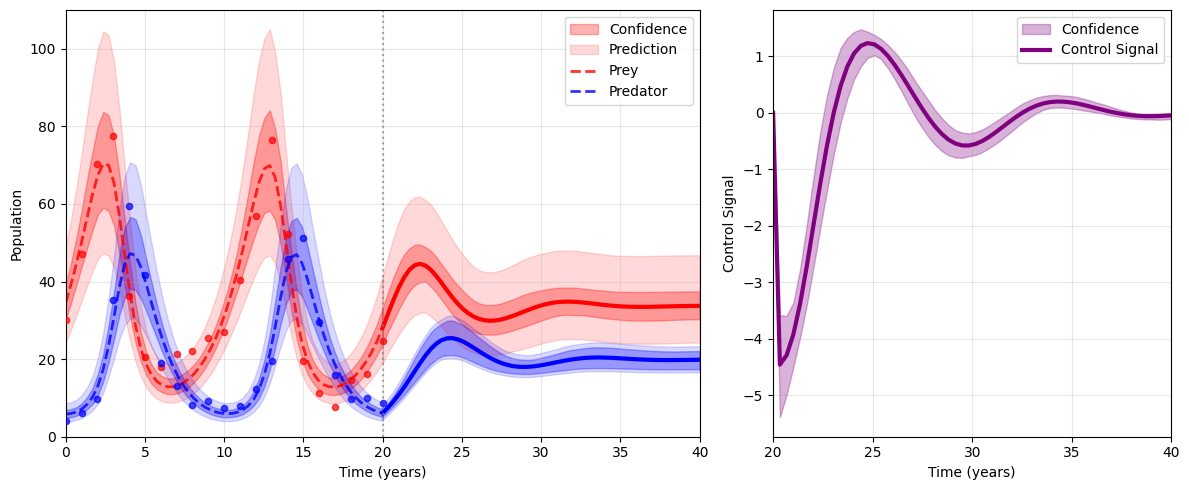

In [41]:
# Fixed noise visualization: Trajectory confidence + constant noise everywhere
# ADJUSTABLE PARAMETER: Set constant_noise_std to use fixed noise level everywhere
sigma = 0.2218

plt.figure(figsize=(12,5))

# CONFIDENCE + NOISE: POPULATION DYNAMICS (takes up ~60% of the width)
plt.subplot2grid((1, 5), (0, 0), colspan=3)

# CONFIDENCE INTERVALS (95% of trajectories) - Base layer
# PREY - Confidence bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
                 prey_uncontrolled_95_lower, 
                 prey_uncontrolled_95_upper, 
                 color='red', alpha=0.3, label='Confidence')

# PREDATOR - Confidence bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
                 predator_uncontrolled_95_lower, 
                 predator_uncontrolled_95_upper, 
                 color='blue', alpha=0.3)

# PREY - Confidence bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                 prey_95_lower, 
                 prey_95_upper, 
                 color='red', alpha=0.3)

# PREDATOR - Confidence bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                 predator_95_lower, 
                 predator_95_upper, 
                 color='blue', alpha=0.3)

# PREY - Prediction bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
            prey_uncontrolled_95_lower * math.exp(-sigma), 
            prey_uncontrolled_95_upper * math.exp(sigma),
                color='red', alpha=0.15, label=f'Prediction')

# PREDATOR - Prediction bands for uncontrolled period (0-20 years)
plt.fill_between(t_uncontrolled, 
            predator_uncontrolled_95_lower * math.exp(-sigma), 
            predator_uncontrolled_95_upper * math.exp(sigma), 
                color='blue', alpha=0.15)

# PREY - Prediction bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                prey_95_lower * math.exp(-sigma), 
                prey_95_upper * math.exp(sigma), 
                color='red', alpha=0.15)

# PREDATOR - Prediction bands for controlled period (20-40 years)
plt.fill_between(time_grid, 
                predator_95_lower - math.exp(-sigma), 
                predator_95_upper + math.exp(sigma), 
                color='blue', alpha=0.15)

# Mean trajectories on top
plt.plot(t_uncontrolled, prey_uncontrolled_mean, 'r--', linewidth=2, alpha=0.8, label='Prey')
plt.plot(t_uncontrolled, predator_uncontrolled_mean, color='blue', linestyle='--', linewidth=2, alpha=0.8, label='Predator')
plt.plot(time_grid, prey_mean, 'r-', linewidth=3)
plt.plot(time_grid, predator_mean, color='blue', linewidth=3)

# Add data points
plt.scatter(t_data, prey_data, color='red', s=20, alpha=0.7, zorder=5)
plt.scatter(t_data, predator_data, color='blue', s=20, alpha=0.7, zorder=5)

plt.axvline(x=20, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('Time (years)')
plt.ylabel('Population')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 40)
plt.ylim(0, 110)

# Plot 2: Control Signal with trajectory confidence + fixed noise overlay (takes up ~40% of the width)
plt.subplot2grid((1, 5), (0, 3), colspan=2)

# CONFIDENCE INTERVALS (95% of control trajectories) - Base layer
plt.fill_between(time_grid, 
                 control_95_lower, 
                 control_95_upper, 
                 color='purple', alpha=0.3, label = 'Confidence')

# Control signal mean on top
plt.plot(time_grid, control_mean, 'purple', linewidth=3, label='Control Signal')

plt.xlabel('Time (years)')
plt.ylabel('Control Signal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(20, 40)
plt.xticks([20, 25, 30, 35, 40])  # Set x-axis ticks to show 4 sections (every 5 years)

plt.tight_layout()

# Save the figure in multiple vector formats
plt.savefig('population_dynamics_uncertainty.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig('population_dynamics_uncertainty.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('population_dynamics_uncertainty.svg', format='svg', dpi=300, bbox_inches='tight')

plt.show()